In [1]:
from itertools import cycle

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from scipy import interp
from sklearn.metrics import auc, classification_report, roc_curve

import torch
from net import IDENet
import sys
import os
import random
import time
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
import pysam
import pytorch_lightning as pl
import ray
import torch
import torch.nn as nn
import torchvision
from hyperopt import hp
from pudb import set_trace
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import (
    TuneReportCallback, TuneReportCheckpointCallback)
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.suggest import Repeater
from ray.tune.suggest.hyperopt import HyperOptSearch

import list2img
import utilities as ut
from net import IDENet

In /home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/xwm/anaconda3/envs/SV/lib/pytho

In [2]:
num_cuda = "2"
bs = 14
os.environ["CUDA_VISIBLE_DEVICES"] = num_cuda
my_label = "7+11channel_predict_5fold"
seed_everything(2022)

# data_dir = "../datasets/NA12878_PacBio_MtSinai/"
data_dir = "/home/xwm/DeepSVFilter/datasets/NA12878_PacBio_MtSinai/"


bam_path = data_dir + "sorted_final_merged.bam"

ins_vcf_filename = data_dir + "insert_result_data.csv.vcf"
del_vcf_filename = data_dir + "delete_result_data.csv.vcf"


all_enforcement_refresh = 0
position_enforcement_refresh = 0
img_enforcement_refresh = 0
sign_enforcement_refresh = 0  # attention
cigar_enforcement_refresh = 0

# get chr list
sam_file = pysam.AlignmentFile(bam_path, "rb")
chr_list = sam_file.references
chr_length = sam_file.lengths
sam_file.close()

hight = 224

Global seed set to 2022


In [3]:
config = {
    "batch_size": bs,
    "beta1": 0.9,
    "beta2": 0.999,
    "lr": 7.187267009530772e-06,
    "weight_decay": 0.0011614665567890423,
    "model_name": "resnet50",
    "KFold": 5,
    "KFold_num": 2,
    #     "classfication_dim_stride": 20, # no use
}

In [4]:
model = IDENet.load_from_checkpoint("/home/xwm/DeepSVFilter/code/checkpoints_predict/7+11channel_predict_5fold/2-epoch=11-validation_f1=0.55-validation_mean=0.62.ckpt", path = data_dir, config=config)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.bias', 'predictions.LayerNorm.weight', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [6]:
model.eval()
result = trainer.test(model)

Load dataset


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Testing: 0it [00:00, ?it/s]

Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/xwm/anaconda3/envs/SV/lib/python3.6/asyncio/base_events.py", line 442, in run_foreve

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'validation_0_pre': 0.5176045894622803,
 'validation_0_re': 0.8078829050064087,
 'validation_1_pre': 0.8505747318267822,
 'validation_1_re': 0.12359818816184998,
 'validation_2_pre': 0.7312002778053284,
 'validation_2_re': 0.9110360145568848,
 'validation_f1': 0.5526878237724304,
 'validation_loss': 0.48772984743118286,
 'validation_loss_epoch': 0.48772984743118286,
 'validation_macro_pre': 0.6997932195663452,
 'validation_macro_re': 0.6141723394393921,
 'validation_mean': 0.6235176920890808}
--------------------------------------------------------------------------------


In [7]:
output = torch.load("result.pt")

In [8]:
y = []
y_hat = []

for out in output:
    y.extend(out['y'])
    y_hat.extend(out['y_hat'])

y = torch.tensor(y).reshape(-1)
y_hat = torch.tensor(y_hat).reshape(-1)

metric = classification_report(y, y_hat, output_dict=True)

In [9]:
metric

{'0': {'precision': 0.5176046176046176,
  'recall': 0.8078828828828829,
  'f1-score': 0.6309586631486367,
  'support': 4440},
 '1': {'precision': 0.8505747126436781,
  'recall': 0.12359818659031258,
  'f1-score': 0.21583333333333335,
  'support': 4191},
 '2': {'precision': 0.7312002892263196,
  'recall': 0.911036036036036,
  'f1-score': 0.8112715603690333,
  'support': 4440},
 'accuracy': 0.623517710963201,
 'macro avg': {'precision': 0.6997932064915385,
  'recall': 0.6141723685030772,
  'f1-score': 0.5526878522836678,
  'support': 13071},
 'weighted avg': {'precision': 0.6969208482150575,
  'recall': 0.623517710963201,
  'f1-score': 0.5591048651532747,
  'support': 13071}}

Confusion matrix, without normalization


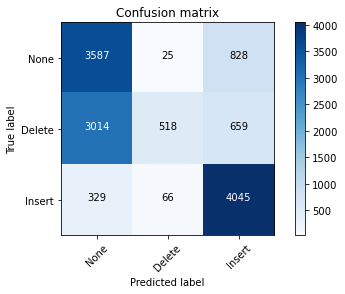

In [10]:
# 导入所需的库
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# 定义真实标签和预测标签
y_true = y
y_pred = y_hat

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)

# 定义类别名称
classes = ["None", "Delete", "Insert"]

# 定义绘制混淆矩阵的函数
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # 显示混淆矩阵的图像
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # 设置标题和颜色条
    plt.title(title)
    plt.colorbar()
    # 设置刻度和标签
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # 根据是否归一化来显示数值
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # 在每个单元格中显示数值
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    # 调整布局和坐标轴标签
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# 调用绘制混淆矩阵的函数
plot_confusion_matrix(cm, classes)

plt.savefig("4-cm.svg", dpi = 600)

# 显示图像
plt.show()

In [11]:
torch.load("/home/xwm/DeepSVFilter/datasets/NA12878_PacBio_MtSinai/del/0.pt")

[{'image': tensor([[[ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           ...,
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.]],
  
          [[ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           ...,
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.],
           [ 4.,  4.,  4.,  ...,  0.,  0.,  0.]],
  
          [[24., 24., 24.,  ...,  0.,  0.,  0.],
           [24., 24., 24.,  ...,  0.,  0.,  0.],
           [24., 24., 24.,  ...,  0.,  0.,  0.],
           ...,
           [24., 24., 24.,  ...,  0.,  0.,  0.],
           [24., 24., 24.,  ...,  0.,  0.,  0.],
           [24., 24., 24.,  ...,  0.,  0.,  0.]],
  
          ...,
  
          [[11., 11., 11.,  ...

In [12]:
torch.load("/home/xwm/DeepSVFilter/datasets/NA12878_PacBio_MtSinai/ins/0.pt")

[{'image': tensor([[[ 17.0000,  17.0000,  17.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 17.0000,  17.0000,  17.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 17.0000,  17.0000,  17.0000,  ...,   0.0000,   0.0000,   0.0000],
           ...,
           [ 17.0000,  17.0000,  17.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 17.0000,  17.0000,  17.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 17.0000,  17.0000,  17.0000,  ...,   0.0000,   0.0000,   0.0000]],
  
          [[ 19.0000,  19.0000,  19.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 19.0000,  19.0000,  19.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 19.0000,  19.0000,  19.0000,  ...,   0.0000,   0.0000,   0.0000],
           ...,
           [ 19.0000,  19.0000,  19.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 19.0000,  19.0000,  19.0000,  ...,   0.0000,   0.0000,   0.0000],
           [ 19.0000,  19.0000,  19.0000,  ...,   0.0000,   0.0000,   0.0000]],
  
   

In [13]:
torch.load("/home/xwm/DeepSVFilter/datasets/NA12878_PacBio_MtSinai/n/0.pt")

[{'image': tensor([[[ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           ...,
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.]],
  
          [[ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           ...,
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.],
           [ 8.,  8.,  8.,  ...,  0.,  0.,  0.]],
  
          [[19., 19., 19.,  ...,  0.,  0.,  0.],
           [19., 19., 19.,  ...,  0.,  0.,  0.],
           [19., 19., 19.,  ...,  0.,  0.,  0.],
           ...,
           [19., 19., 19.,  ...,  0.,  0.,  0.],
           [19., 19., 19.,  ...,  0.,  0.,  0.],
           [19., 19., 19.,  ...,  0.,  0.,  0.]],
  
          ...,
  
          [[44., 44., 44.,  ...